# Import Lib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Input, Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.graph_objects as go

from google.colab import drive
import os

# PATH

In [2]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/')

project_path = "Report_DBA/"
source_path = project_path + "source/"
data_path = project_path + "data/BTC-USD.csv"

Mounted at /content/drive/


In [3]:
df = pd.read_csv(data_path)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1822,04/22/2023,27265.89453,27872.14258,27169.57031,27817.50000,27817.50000,1.312573e+10
1823,04/23/2023,27816.14453,27820.24414,27400.31445,27591.38477,27591.38477,1.278545e+10
1824,04/24/2023,27591.73047,27979.98242,27070.84961,27525.33984,27525.33984,1.770329e+10
1825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   Open       1825 non-null   float64
 2   High       1825 non-null   float64
 3   Low        1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Adj Close  1825 non-null   float64
 6   Volume     1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 100.0+ KB


Nhận thấy dữ liệu có 1827 dòng nhưng có 2 dòng bị thiếu ==> Vậy nên cần xử lý các dòng đó

In [5]:
# do 2 dòng này nằm cuối dữ liệu nên không cần tìm giá trị thay thế mà trực tiếp loại bỏ
df.dropna(inplace=True)

# Plot

In [6]:
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Train Test vs Validation Split

In [7]:
n_observations = df.shape[0]
features = ["Open", "High", "Low", "Volume", "Adj Close"]

df = df[ features]
train = df[:int(n_observations*0.7)]
test = df[int(n_observations*0.7): int(n_observations*0.9)]
val = df[int(n_observations*0.9):]

# Helper Functions

In [8]:
def to_supervised(data, lookback = 3):
    n = data.shape[0]
    X, y = list(), list()
    for i in range(n - lookback):
        X.append(data[i: i + lookback])
        y.append(data[i+lookback, -1])
    return np.array(X), np.array(y)

# Main Run

## Prepare data

In [9]:
scaler = MinMaxScaler().fit(train)
y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

train_X, train_y= to_supervised(train_scaled, 3)
test_X, test_y = to_supervised(test_scaled, 3)
val_X, val_y = to_supervised(val_scaled, 3)

## LSTM Model

In [10]:
lstm_model = Sequential()

lstm_model.add(Input(shape=train_X.shape[1:]))
lstm_model.add(LSTM(128))
# Add a Dense layer using for ouput
lstm_model.add(Dense(1))

lstm_model.compile(loss='mse',
                  optimizer='adam',
                   metrics=[
                       'mae', tf.keras.metrics.RootMeanSquaredError() , 'mape'
                   ])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68608     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________


## Train data

In [11]:
history = lstm_model.fit(train_X, train_y, 
          epochs=350, 
          batch_size=32, 
          validation_data=(val_X, val_y))

Epoch 1/350
40/40 [==============================] - 5s 36ms/step - loss: 0.0155 - mae: 0.0727 - root_mean_squared_error: 0.1247 - mape: 80908.1797 - val_loss: 5.3948e-04 - val_mae: 0.0192 - val_root_mean_squared_error: 0.0232 - val_mape: 6.4476
Epoch 2/350
40/40 [==============================] - 1s 13ms/step - loss: 6.0276e-04 - mae: 0.0138 - root_mean_squared_error: 0.0246 - mape: 745.3213 - val_loss: 2.2514e-04 - val_mae: 0.0096 - val_root_mean_squared_error: 0.0150 - val_mape: 3.2809
Epoch 3/350
40/40 [==============================] - 0s 9ms/step - loss: 5.1119e-04 - mae: 0.0125 - root_mean_squared_error: 0.0226 - mape: 5166.2603 - val_loss: 2.7462e-04 - val_mae: 0.0116 - val_root_mean_squared_error: 0.0166 - val_mape: 3.9475
Epoch 4/350
40/40 [==============================] - 0s 10ms/step - loss: 5.1473e-04 - mae: 0.0126 - root_mean_squared_error: 0.0227 - mape: 6062.3721 - val_loss: 2.2239e-04 - val_mae: 0.0095 - val_root_mean_squared_error: 0.0149 - val_mape: 3.2432
Epoch 5/3

## Test data

12/12 [==============================] - 1s 5ms/step


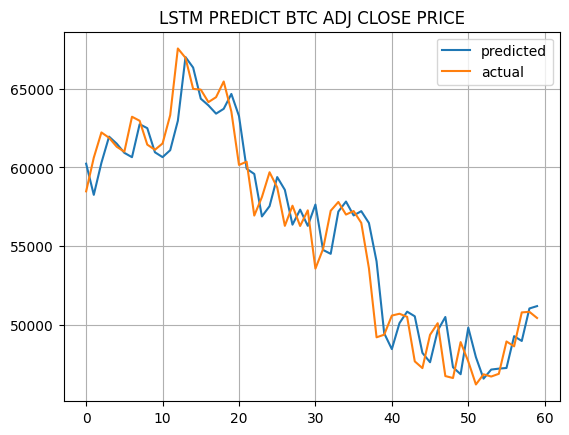

In [12]:
# number of days used for flotting
days = 60

pred = lstm_model.predict(test_X)

# inverse data to origin values
y_predicted = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )

# plot
plt.grid(True)
plt.plot(y_predicted[:days], label="predicted")
plt.plot(y_true[:days], label="actual")
plt.title("LSTM PREDICT BTC ADJ CLOSE PRICE")
plt.legend()
plt.show()

# Evaluate


In [13]:
mae = mean_absolute_error(y_true, y_predicted)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
mape = mean_absolute_percentage_error(y_true, y_predicted)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 924.6795360462705
RMSE: 1330.063007383777
mape: 0.02696635701328322


# Tuning Hyperparameters

In [14]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.0 MB/s eta 0:00:00


In [15]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-15-2bbfbe7dae29>:1: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



In [16]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=train_X.shape[1:]))
    
    model.add(LSTM(units=hp.Int(f'lstm_units', min_value=32, max_value=512, step=16)))
    
    num_dense = hp.Int("num_dense", min_value=0, max_value=5, step=1)
    # Tune the number of Dense Layers
    for i in range(num_dense):
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=16)))
    
    model.add(Dense(1))
    
    # lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling='log')
        
    model.compile(loss='mse',
                  optimizer='adam',
                   metrics=[
                       'mae', tf.keras.metrics.RootMeanSquaredError() , 'mape'
                   ])
    return model

In [33]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='TUNING',
    project_name='LSTM')

In [34]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8)
tuner.search(train_X, train_y,
             epochs=150,
             validation_data=(val_X, val_y),
            callbacks=[early_stop])

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 51s]
val_loss: 0.00017131616186816245

Best val_loss So Far: 0.00010946398591234659
Total elapsed time: 00h 21m 48s


In [35]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352)               504064    
                                                                 
 dense (Dense)               (None, 96)                33888     
                                                                 
 dense_1 (Dense)             (None, 432)               41904     
                                                                 
 dense_2 (Dense)             (None, 1)                 433       
                                                                 
Total params: 580,289
Trainable params: 580,289
Non-trainable params: 0
_________________________________________________________________


## Build model with best hyperparameters 

In [36]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
model.fit(train_X, train_y, 
          epochs = 300,
          batch_size = 32,
         validation_data=(val_X, val_y))

Epoch 1/300
40/40 [==============================] - 5s 43ms/step - loss: 0.0115 - mae: 0.0550 - root_mean_squared_error: 0.1073 - mape: 18864.3477 - val_loss: 4.2425e-04 - val_mae: 0.0174 - val_root_mean_squared_error: 0.0206 - val_mape: 6.0760
Epoch 2/300
40/40 [==============================] - 1s 28ms/step - loss: 5.4977e-04 - mae: 0.0142 - root_mean_squared_error: 0.0234 - mape: 5992.6729 - val_loss: 3.4110e-04 - val_mae: 0.0153 - val_root_mean_squared_error: 0.0185 - val_mape: 5.4194
Epoch 3/300
40/40 [==============================] - 1s 26ms/step - loss: 6.5704e-04 - mae: 0.0148 - root_mean_squared_error: 0.0256 - mape: 740.1869 - val_loss: 1.8557e-04 - val_mae: 0.0086 - val_root_mean_squared_error: 0.0136 - val_mape: 2.9156
Epoch 4/300
40/40 [==============================] - 1s 25ms/step - loss: 8.4407e-04 - mae: 0.0171 - root_mean_squared_error: 0.0291 - mape: 6757.3398 - val_loss: 4.5939e-04 - val_mae: 0.0179 - val_root_mean_squared_error: 0.0214 - val_mape: 6.0933
Epoch 5/

## tesst

12/12 [==============================] - 1s 7ms/step


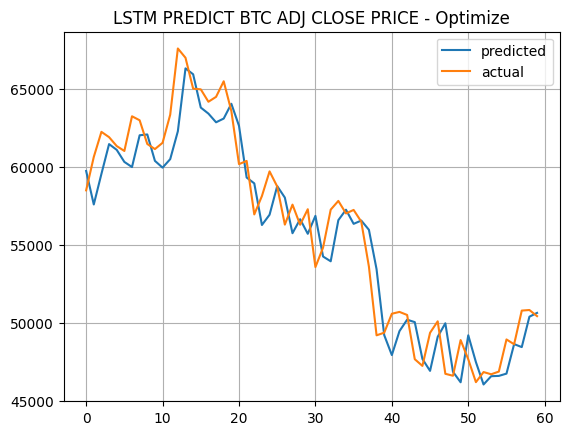

In [37]:
days = 60
pred = model.predict(test_X)
y_predicted = y_scaler.inverse_transform(np.array(pred).reshape(-1, 1)).reshape(-1, )
y_true = y_scaler.inverse_transform(np.array(test_y).reshape(-1, 1)).reshape(-1, )
plt.grid(True)
plt.plot(y_predicted[:days], label="predicted")
plt.plot(y_true[:days], label="actual")
plt.title("LSTM PREDICT BTC ADJ CLOSE PRICE - Optimize")
plt.legend()
plt.show()

## Evaluate

In [31]:
mae = mean_absolute_error(y_true, y_predicted)
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
mape = mean_absolute_percentage_error(y_true, y_predicted)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"mape: {mape}")

MAE: 1046.3514972064916
RMSE: 1455.565916449745
mape: 0.03024025487267546
